# Synthetic Data Generation with GWKokab

In this notebook we'll learn how to leverage GWKokab to generate synthetic data. Let's get started and discover how GWKokab can help us generate high-quality synthetic data!

We are generating data from `PowerlawPrimaryMassRatio`, see eq (7) of [Wysocki et al](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.100.043012), for the primary and secondary mass of the binary system, and Truncated Normal distribution for the eccentricity of the orbit. The models are defined as follows:

$$
    p(m_1,q\mid\alpha,\beta,m_{\text{min}},m_{\text{max}})\propto
    m_1^{-\alpha}q^{\beta} \qquad \mathcal{N}_{[a,b]}(\varepsilon\mid\mu,\sigma^2)\propto\exp\left(-\frac{1}{2}\left(\frac{\varepsilon-\mu}{\sigma}\right)^2\right)\mathbb{1}_{[a,b]}(\varepsilon)
$$

## Environment Variables

GWKokab at its core used JAX for fast computation. To setup the behavior of JAX based on the accelerator you are using, you have to set the environment variables. Here are the environment variables that you can set:

In [1]:
import os


env_vars = {
    "JAX_COMPILATION_CACHE_DIR": "jax_cache",
    "JAX_ENABLE_X64": "1",
    "JAX_PLATFORM_NAME": "cpu",
    "NPROC": "16",
    "XLA_FLAGS": "--xla_cpu_multi_thread_eigen=false",
    "XLA_PYTHON_CLIENT_ALLOCATOR": "platform",
}

for var, value in env_vars.items():
    os.environ[var] = value

## Importing libraries

Importing the required libraries for the code. 

In [ ]:
import numpy as np
import numpyro
from jax import nn as jnn, numpy as jnp, random as jrd
from jaxtyping import ArrayLike
from matplotlib import pyplot as plt
from numpyro import distributions as dist

from gwkokab.errors import banana_error_m1_m2, truncated_normal_error
from gwkokab.models import PowerlawPrimaryMassRatio
from gwkokab.models.transformations import (
    PrimaryMassAndMassRatioToComponentMassesTransform,
)
from gwkokab.models.utils import JointDistribution, ScaledMixture
from gwkokab.parameters import ECCENTRICITY, PRIMARY_MASS_SOURCE, SECONDARY_MASS_SOURCE
from gwkokab.poisson_mean import PoissonMean
from gwkokab.population import error_magazine, PopulationFactory
from gwkokab.vts import NeuralNetVolumeTimeSensitivity

/home/gradf/.conda/envs/gwkenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/gradf/.conda/envs/gwkenv/lib/python3.12/site-packages/igwn_ligolw/lsctables.py:57: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal
2025-05-16 18:54:17.009 | DEBUG    | Setting LogLevel to TRACE
202

In [19]:
numpyro.enable_validation()


plt.rcParams.update(
    {
        "text.usetex": True,
        "font.size": 12,
        "font.family": "Times New Roman",
    }
)

By enabling validation of NumPyro distributions in the statement `numpyro.enable_validation()` we can ensure that the values that are outside the support of the distribution return `0.0` probability.

## Parameters and Priors

Setting up the parameters and priors for the model. `params` contains the parameters for the model to generate data, while `model_params` contains the parameters for the model to run inference. `err` contains the error values for the model.

In [ ]:
params = {
    "alpha": 3.0,
    "beta": -2.0,
    "log_rate": 3.0,
    "mmax": 100.0,
    "mmin": 50.0,
    "loc": 0.0,
    "scale": 0.5,
}

In [4]:
parameters = [PRIMARY_MASS_SOURCE.name, SECONDARY_MASS_SOURCE.name, ECCENTRICITY.name]

## Model

Model definition is an integral part of GWKokab. A properly defined model is essential for correct inference. Each model is a probability distribution which is a subclass of [`numpyro.distributions.Distribution`](https://num.pyro.ai/en/stable/distributions.html#distribution).  We can also combine independent distributions to create a more complex model using [`gwkokab.model.utils.JointDistribution`](https://gwkokab.readthedocs.io/en/latest/autoapi/gwkokab/models/utils/index.html#gwkokab.models.utils.JointDistribution). GWKokab is built for the inference of multi source population, which means each source would have its own model as well as their own rate. We have to scale each subpopulation model by its rate and combine them to create the final model. This is a standard approach to build and combine any model in GWKokab and the final model is of type [`gwkokab.models.utils.ScaledMixture`][ScaledMixture].

For this tutorial we have the mass model defined as,

$$
     p(m_1,q\mid\alpha,\beta,m_{\text{min}},m_{\text{max}})\propto
    m_1^{-\alpha}q^{\beta}
$$

and our eccentricity model is defined as,

$$
    \mathcal{N}_{[a,b]}(\varepsilon\mid\mu,\sigma^2)\propto\exp\left(-\frac{1}{2}\left(\frac{\varepsilon-\mu}{\sigma}\right)^2\right)\mathbb{1}_{[a,b]}(\varepsilon)
$$

We will write a `model_builder` function that will take the parameters of the model and return a [`ScaledMixture`][ScaledMixture] object.

[ScaledMixture]: https://gwkokab.readthedocs.io/en/latest/autoapi/gwkokab/models/utils/index.html#gwkokab.models.utils.ScaledMixture

In [5]:
def model_builder(
    log_rate: ArrayLike,
    alpha: ArrayLike,
    beta: ArrayLike,
    mmax: ArrayLike,
    mmin: ArrayLike,
    loc: ArrayLike,
    scale: ArrayLike,
) -> ScaledMixture:
    """Scaled Joint Distribution of Primary Mass, Secondary Mass and Eccentricity.

    Parameters
    ----------
    log_rate : ArrayLike
        Merger rate of the population
    alpha : ArrayLike
        powerlaw index for the primary mass
    beta : ArrayLike
        powerlaw index for the mass ratio
    mmax : ArrayLike
        Maximum mass
    mmin : ArrayLike
        Minimum mass
    loc : ArrayLike
        mean of the gaussian distribution of eccentricity
    scale : ArrayLike
        standard deviation of the gaussian distribution of eccentricity

    Returns
    -------
    ScaledMixture
        A mixture of distributions for the primary mass, secondary mass and eccentricity
    """
    mass_model = dist.TransformedDistribution(
        PowerlawPrimaryMassRatio(
            alpha=alpha, beta=beta, mmax=mmax, mmin=mmin, validate_args=True
        ),
        PrimaryMassAndMassRatioToComponentMassesTransform(),
        validate_args=True,
    )
    eccentricity_model = dist.Normal(loc=loc, scale=scale, validate_args=True)
    component_distributions = JointDistribution(
        mass_model, eccentricity_model, validate_args=True
    )
    return ScaledMixture(
        log_scales=jnp.array([log_rate]),
        component_distributions=[component_distributions],
        validate_args=True,
    )

[`PowerlawPrimaryMassRatio`][PowerlawPrimaryMassRatio] is defined in for primary mass and mass ratio. As a standard we use primary mass and secondary mass for inference and data generation, therefore the distribution is transformed for primary mass and secondary mass using [`numpyro.distributions.TransformedDistribution`][TransformedDistribution] with appropriate transformation i.e. [`PrimaryMassAndMassRatioToComponentMassesTransform`][PrimaryMassAndMassRatioToComponentMassesTransform] which will convert the primary mass and mass ratio to component masses.

[PowerlawPrimaryMassRatio]: https://gwkokab.readthedocs.io/en/latest/autoapi/gwkokab/models/index.html#gwkokab.models.PowerlawPrimaryMassRatio
[TransformedDistribution]: https://num.pyro.ai/en/stable/distributions.html#transformeddistribution
[PrimaryMassAndMassRatioToComponentMassesTransform]: https://gwkokab.readthedocs.io/en/latest/autoapi/gwkokab/models/transformations/index.html#gwkokab.models.transformations.PrimaryMassAndMassRatioToComponentMassesTransform

In [ ]:
model = model_builder(**params)

## Setup VT

GWKokab estimates the Volume Time Sensitivity (VT) using neural networks. We use [MLPs][MLP] with [ReLU][ReLU] activation to work as piece wise linear estimation of the surface formed by the sensitivity curve. The [MLP][MLP] is trained using the precomputed values of sensitivity. Experimentally we found that the [MLP][MLP] is good at learning $\ln\operatorname{VT}(\omega)$ rather than $\operatorname{VT}(\omega)$, therefore functionally we use the `log` of the VT. We call them Neural VTs. We have trained different Neural VTs and their weights are available at [`gwkokab/asset-store/neural_vts`](https://github.com/gwkokab/asset-store/tree/main/neural_vts).

Downloading weights from asset-store:

[MLP]: https://en.wikipedia.org/wiki/Multilayer_perceptron
[ReLU]: https://en.wikipedia.org/wiki/Relu

In [7]:
!wget -c "https://github.com/gwkokab/asset-store/raw/refs/heads/main/neural_vts/neural_vt_0p5_200_1_PSDaLIGOEarlyHighSensitivityP1200087_IMRPhenomPv2.hdf5" -O neural_vt_0p5_200_1_PSDaLIGOEarlyHighSensitivityP1200087_IMRPhenomPv2.hdf5

--2025-05-16 18:54:17--  https://github.com/gwkokab/asset-store/raw/refs/heads/main/neural_vts/neural_vt_0p5_200_1_PSDaLIGOEarlyHighSensitivityP1200087_IMRPhenomPv2.hdf5
Resolving github.com (github.com)... 20.207.73.82
Connecting to github.com (github.com)|20.207.73.82|:443... 

/home/gradf/.conda/envs/gwkenv/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gwkokab/asset-store/refs/heads/main/neural_vts/neural_vt_0p5_200_1_PSDaLIGOEarlyHighSensitivityP1200087_IMRPhenomPv2.hdf5 [following]
--2025-05-16 18:54:18--  https://raw.githubusercontent.com/gwkokab/asset-store/refs/heads/main/neural_vts/neural_vt_0p5_200_1_PSDaLIGOEarlyHighSensitivityP1200087_IMRPhenomPv2.hdf5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 412520 (403K) [application/octet-stream]
Saving to: ‘neural_vt_0p5_200_1_PSDaLIGOEarlyHighSensitivityP1200087_IMRPhenomPv2.hdf5’

neural_vt_0p5_200_1 100%[===================>] 402.85K  2.42MB/s    in 0.2s    

2025-05-16 18:54:18 (2.42 MB/s) - ‘neural_vt_0p5_200_1_PSDaLIGOEarlyHighSensitivityP12000

In [8]:
filename = "neural_vt_0p5_200_1_PSDaLIGOEarlyHighSensitivityP1200087_IMRPhenomPv2.hdf5"


nvt = NeuralNetVolumeTimeSensitivity(
    parameters=parameters,
    filename=filename,
    batch_size=1000,
)
logVT_fn = nvt.get_mapped_logVT()  # mapped logVT function

## Setup Poisson Mean

Poisson Mean is the expectation of VT with respect to the population model. It is estimated using Monte Carlo integration. When the population model can be sampled it is recommended to use the Inverse Transform Sampling method along with the Monte Carlo integration (most accurate of all). And when the population model can not be sampled, we can should use the Importance Sampling method.

The API for the Poisson Mean is designed to be flexible in a way that user can choose the method of integration for each component of the model. We pass `"self"` if we want to use the Inverse Transform Sampling method, otherwise a list of numpyro distributions ordered by the intrinsic parameters of the model.

For more details, see documentation of [`gwkokab.poisson_mean.PoissonMean`][PoissonMean].

[PoissonMean]: https://gwkokab.readthedocs.io/en/latest/autoapi/gwkokab/poisson_mean/index.html

In [9]:
erate_estimator = PoissonMean(
    nvt,
    key=jrd.PRNGKey(19),
    num_samples=10_000,
    proposal_dists=["self"],
    time_scale=500.0,
)  # type: ignore[arg-type]

## Generate Data

We have selected the model to generate injections. To simulate injections as events detected by the LVK detectors we add synthetic error in each injections. We can add any type of error in the injections. The API for error to take injection as first argument, size of error as second argument and the [`jax.random.PRNGKey`](https://docs.jax.dev/en/latest/_autosummary/jax.random.PRNGKey.html) as the thirds argument. The function returns an array of values which represents error added into a single injection. This function will be applied to each injection.

In this example we are adding [`banana_error_m1_m2`](https://gwkokab.readthedocs.io/en/latest/autoapi/gwkokab/errors/index.html#gwkokab.errors.banana_error_m1_m2) error in component masses and truncated normal error in eccentricity.

In [10]:
error_magazine.register(  # m1 and m2 error
    (parameters[0], parameters[1]),
    lambda x, size, key: banana_error_m1_m2(x, size, key, scale_Mc=1.0, scale_eta=1.0),
)


error_magazine.register(  # eccentricity error
    parameters[2],
    lambda x, size, key: truncated_normal_error(
        x,
        size,
        key,
        scale=0.06,
        low=0.0,
        high=1.0,
        cut_low=0.0,
        cut_high=1.0,
    ),
)

<function __main__.<lambda>(x, size, key)>

In [11]:
pop = PopulationFactory(
    model=model,
    parameters=parameters,
    logVT_fn=logVT_fn,
    ERate_fn=erate_estimator.__call__,
)

In [12]:
pop.produce()

/home/gradf/.conda/envs/gwkenv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/gradf/.conda/envs/gwkenv/lib/python3.12/site-packages/gwkokab/population/_factory.py:239: UserWarning: 
Skipping file 106 due to all NaN values or insufficient data.
  warnings.warn(

## Selecting Realization to continue

`realization_number` is set to the number of realization we want to continue with.

In [13]:
realization_number = 0
datapath = f"data/realization_{realization_number}/injections.dat"
raw_datapath = f"data/realization_{realization_number}/raw_injections.dat"
POSTERIOR_REGEX = f"data/realization_{realization_number}/posteriors/event_*.dat"

In [14]:
data_inj = np.loadtxt(datapath, skiprows=1)
raw_data_inj = np.loadtxt(raw_datapath, skiprows=1)

<>:16: SyntaxWarning: invalid escape sequence '\o'
<>:17: SyntaxWarning: invalid escape sequence '\o'
<>:16: SyntaxWarning: invalid escape sequence '\o'
<>:17: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_11928/2055703415.py:16: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel("Primary mass (M$_\odot$)")
/tmp/ipykernel_11928/2055703415.py:17: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel("Secondary mass (M$_\odot$)")


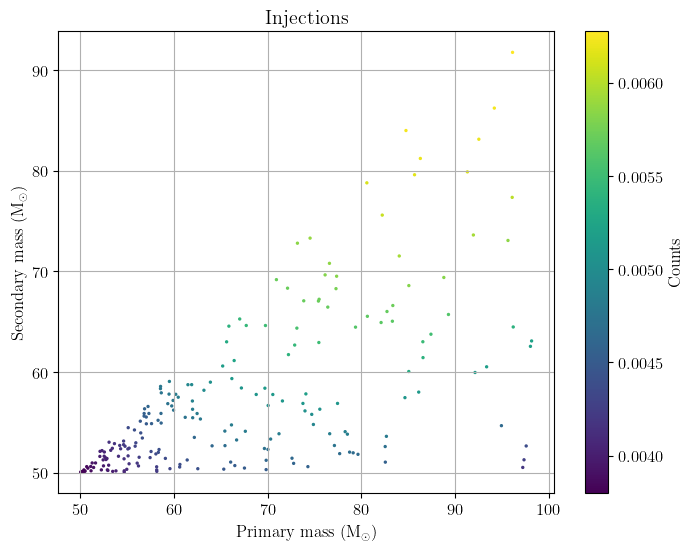

In [20]:
log_probs = logVT_fn(data_inj)
vt = jnp.nan_to_num(log_probs, nan=-jnp.inf)
vt = jnn.softmax(log_probs)


plt.figure(figsize=(8, 6))
plt.scatter(
    data_inj[:, 0],
    data_inj[:, 1],
    s=2,
    c=vt,
    label="Injections",
    cmap="viridis",
)
plt.colorbar(label="Counts")
plt.xlabel("Primary mass (M$_\odot$)")
plt.ylabel("Secondary mass (M$_\odot$)")
plt.title("Injections")
plt.grid()

<>:15: SyntaxWarning: invalid escape sequence '\o'
<>:16: SyntaxWarning: invalid escape sequence '\o'
<>:15: SyntaxWarning: invalid escape sequence '\o'
<>:16: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_11928/1945385914.py:15: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel("Primary mass (M$_\odot$)")
/tmp/ipykernel_11928/1945385914.py:16: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel("Secondary mass (M$_\odot$)")


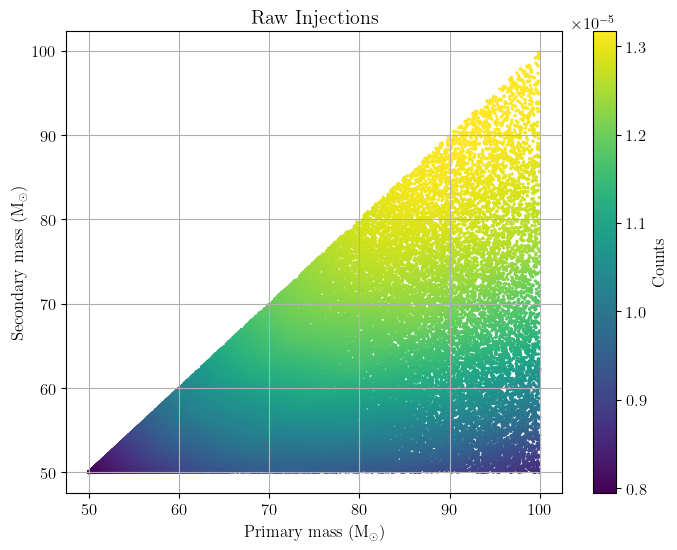

In [21]:
log_probs = logVT_fn(raw_data_inj)
vt = jnp.nan_to_num(log_probs, nan=-jnp.inf)
vt = jnn.softmax(log_probs)


plt.figure(figsize=(8, 6))
plt.scatter(
    raw_data_inj[:, 0],
    raw_data_inj[:, 1],
    s=2,
    c=vt,
    cmap="viridis",
)
plt.colorbar(label="Counts")
plt.xlabel("Primary mass (M$_\odot$)")
plt.ylabel("Secondary mass (M$_\odot$)")
plt.title("Raw Injections")
plt.grid()